In [1]:
from constants import *
from utils import *
from modules import *

In [2]:
import random
import time
from collections import Counter
from collections import defaultdict
%matplotlib inline
random.seed(2019)

In [3]:
model_id = 'rmn'

## Input

In [4]:
bmap, cmap, wmap, revmap, span_data, span_size, target_pred_ix_set, We = load_data(data_load_path)

num_chars, num_books, num_traj = len(cmap), len(bmap), len(span_data)

In [5]:
descriptor_log = 'descriptors_model_' + str(model_id) + '.log'

trajectory_log = 'trajectories_model_' + str(model_id) + '.log'

training_progress_log = 'training_progress_log_' + str(model_id) + '.txt'

model_object_file_name = 'trained_model_' + str(model_id) + '.pt'

## Model

In [6]:
class RMN(nn.Module):

    def __init__(self, d_word, d_ent, d_meta, d_mix, d_desc, n_ent, n_meta, We):
        super(RMN, self).__init__()
        self.d_desc = d_desc
        self.l_st = TrainedWordEmbeddingLayer(torch.FloatTensor(We).to(device), d_word)
        self.l_ent = nn.Embedding(n_ent, d_ent)
        self.l_meta = nn.Embedding(n_meta, d_meta)
        self.l_mix = MixingLayer(d_word, d_ent, d_meta, d_mix)
        self.l_rels = LinearRNN(d_mix, d_desc)
        self.l_recon = nn.Linear(d_desc, d_word)
        nn.init.xavier_uniform_(self.l_recon.weight)
    
    def init_hidden(self):
        self.l_rels.begin = True

    def forward(self, spans, e1, e2, meta):
        e1_tensor = torch.LongTensor(e1).to(device)
        e2_tensor = torch.LongTensor(e2).to(device)
        meta_tensor = torch.LongTensor(meta).to(device)
        
        outputs_l_st = self.l_st(spans)
        outputs_l_e1 = self.l_ent(e1_tensor).expand(len(spans), -1)
        outputs_l_e2 = self.l_ent(e2_tensor).expand(len(spans), -1)
        outputs_l_meta = self.l_meta(meta_tensor).expand(len(spans), -1)
        
        outputs_l_mix = self.l_mix(outputs_l_st, outputs_l_e1, outputs_l_e2, outputs_l_meta)
        
        outputs_l_rels = torch.zeros([len(spans), self.d_desc], dtype=torch.float).to(device)
        for i, olm in enumerate(outputs_l_mix):
            outputs_l_rels[i], self.l_rels.hidden = self.l_rels(olm, self.l_rels.hidden)
        
        outputs = self.l_recon(outputs_l_rels)
        return outputs, outputs_l_rels

## Training

In [ ]:
model = RMN(d_word, d_char, d_book, d_mix, num_descs, num_chars, num_books, We).to(device)
loss_function = Contrastive_Max_Margin_Loss().to(device)
optimizer = optim.Adam(filter(lambda x: x.requires_grad, model.parameters()), lr=lr)
label_generation_layer = TrainedWordEmbeddingLayer(torch.FloatTensor(We), d_word).to(device)

for epoch in range(n_epochs):
    epoch_start_t = time.time()
    epoch_total_loss = torch.tensor(0.).to(device)
    random.shuffle(span_data)
    
    for book, chars, big_spans, big_masks, big_months, _ in span_data:
        
        split_indices = [i for i in range(0, len(big_spans), batch_size)] # split to batches to fit in memory
        spans_split = np.split(big_spans, split_indices)
        masks_split = np.split(big_masks, split_indices)
        months_split = np.split(big_months, split_indices)
        for spans, masks, months in zip(spans_split, masks_split, months_split):
            if len(spans) != batch_size:
                continue
        
            char1 = [chars[0]]
            char2 = [chars[1]]

            model.zero_grad()
            model.init_hidden()

            train_masked_spans = []
            drop_masks = (np.random.rand(*(masks.shape)) < (1 - p_drop)).astype('float32')
            for span_index, (span, mask, drop_mask) in enumerate(zip(spans, masks, drop_masks)):
                train_masked_span = [span[i] for i in range(len(span))
                                     if (mask[i] == all_ix)
                                     and (drop_mask[i] == 1)]
                train_masked_spans.append(train_masked_span)

            pos_masked_spans = []
            for span_index, (span, mask) in enumerate(zip(spans, masks)):
                pos_masked_span = [span[i] for i in range(len(span))
                                     if (mask[i] == all_ix)]
                pos_masked_spans.append(pos_masked_span)

            neg_spans, neg_masks = generate_negative_samples(num_traj, span_size,
                                                             num_negs, span_data)
            neg_masked_spans = []
            for span_index, (span, mask) in enumerate(zip(neg_spans, neg_masks)):
                neg_masked_span = [span[i] for i in range(len(span))
                                     if (mask[i] == all_ix)]
                neg_masked_spans.append(neg_masked_span)

            outputs, _outputs_l_rels = model(train_masked_spans, char1, char2, book)
            pos_labels = label_generation_layer(pos_masked_spans)
            neg_labels = label_generation_layer(neg_masked_spans)

            R = torch.t(model.l_recon.weight)

            loss = loss_function(outputs, pos_labels, neg_labels, len(spans), R, eps, d_word)

            loss.backward()
            optimizer.step()
            epoch_total_loss += loss
    
    print("epoch %d finished in %.2f seconds" % (epoch, (time.time() - epoch_start_t)))
    print(epoch_total_loss)
    f_tpl = open(training_progress_log, 'a')
    f_tpl.write('epoch ' + str(epoch) + ': ' + str(time.time() - epoch_start_t) + '\n')
    f_tpl.close()

In [ ]:
torch.save(model, model_object_file_name)

## Trained Model

In [9]:
model = torch.load(model_object_file_name)

## Descriptors Generation

In [10]:
target_word_ix_set = set()
target_word_ix_counter = Counter()

for _, _, spans, masks, _ , _ in span_data:
    for span, mask in zip(spans, masks):
        for w, m in zip(span, mask):
            if m == all_ix:
                target_word_ix_counter[w] += 1
                
for wix, _ in target_word_ix_counter.most_common()[:500]: # can also do without the 500 top word limit, but less interpretable
    target_word_ix_set.add(wix)

In [11]:
log = open(descriptor_log, 'w')

R = torch.t(model.l_recon.weight).detach().cpu().numpy()
for ind in range(len(R)):
    desc = R[ind] / np.linalg.norm(R[ind])
    top_desc_list = []
    
    sims = We.dot(np.transpose(desc))
    ordered_words = np.argsort(sims)[::-1]

    desc_list = []
    num_satisfied = 0
    for w in ordered_words:
        if num_satisfied >= num_descs_choice:
            break
        if w in target_word_ix_set:
            desc_list.append(revmap[w])
            num_satisfied += 1
    
    sentiment_score = calc_desc_sentiment(desc_list)
    top_desc_list.append('-'.join(desc_list) + ' [' + str(sentiment_score) + ']')

    print('descriptor %d:' % ind)
    print(top_desc_list)
    print()

    log.write(' '.join(top_desc_list) + '\n')
log.flush()
log.close()

descriptor 0:
['aircraft-usd-fighter-datum-spy [0.1531]']

descriptor 1:
['terrorism-militant-terror-terrorist-condemn [-0.946]']

descriptor 2:
['theresa-emmanuel-yemen-poland-lebanon [0.0]']

descriptor 3:
['seem-thing-though-too-especially [0.0]']

descriptor 4:
['negotiate-establish-impose-propose-negotiation [-0.296]']

descriptor 5:
['giant-rival-maker-dispute-phone [-0.4019]']

descriptor 6:
['propose-woman-represent-indians-spend [0.0]']

descriptor 7:
['match-victory-player-defeat-game [-0.4588]']

descriptor 8:
['series-online-advance-battle-defeat [-0.6808]']

descriptor 9:
['republican-democratic-opposition-oppose-congress [0.0]']

descriptor 10:
['cost-cite-compare-co-m [0.0]']

descriptor 11:
['partnership-militant-organization-community-alliance [0.0]']

descriptor 12:
['range-information-supply-infrastructure-value [0.34]']

descriptor 13:
['euro-revenue-boost-financial-crisis [-0.34]']

descriptor 14:
['protest-push-stop-arab-visa [-0.4939]']

descriptor 15:
['southeas

## Temporal Trend Generation

In [12]:
tlog = open(trajectory_log, 'w')
traj_writer = csv.writer(tlog)
traj_writer.writerow(['Book', 'Char 1', 'Char 2', 'Span ID'] + ['Topic ' + str(i) for i in range(num_descs)])

with torch.no_grad():
    for book, chars, spans, masks, months, samples in span_data:
        c1_name, c2_name = [cmap[c] for c in chars]
        b_name = bmap[book[0]]

        char1 = [chars[0]]
        char2 = [chars[1]]

        model.zero_grad()
        model.hidden = model.init_hidden()

        masked_spans = []
        for span_index, (span, mask) in enumerate(zip(spans, masks)):
            masked_span = [span[i] for i in range(len(span))
                                     if (mask[i] == all_ix)]
            masked_spans.append(masked_span)

        _outputs, outputs_l_rels = model(masked_spans, char1, char2, book)

        for span_index, olr in enumerate(outputs_l_rels.detach().cpu().numpy()):
            traj_writer.writerow([b_name, c1_name, c2_name, months[span_index], span_index] + [o for o in olr])

tlog.flush()
tlog.close()

In [13]:
vis_dict = dict()
num_top_descs = 3 # to get an overview for all descriptors, change this to 30

In [14]:
major_desc_sum_dict = defaultdict(float)

rmn_traj = read_csv(trajectory_log)
rmn_descs = read_descriptors(descriptor_log)

for book in rmn_traj:
    for rel in rmn_traj[book]:
        if rel not in interest_pairs:
            continue
            
        plt.close()
        
        rtraj = rmn_traj[book][rel]['distributions']
        mtraj = rmn_traj[book][rel]['months']
        itraj = rmn_traj[book][rel]['span_index']
        
        data_d = dict()
        desc_sum_d = defaultdict(float)
        trivial_descs = set()
        
        # find non-trivial descs
        for i in range(num_descs):
            data_d[i] = defaultdict(list)
        for r, m in zip(rtraj, mtraj):
            for i, desc in enumerate(r):
                data_d[i][m].append(desc)
        for i in data_d.keys():
            trivial = True
            for m in data_d[i].keys():
                desc_sum_d[i] += np.mean(data_d[i][m])

        top_ds = [top_d[0] for top_d in sorted([(i, share) for i, share in desc_sum_d.items()],
                                               key=lambda x: -x[1])[:num_top_descs]] # get top three descriptors
        
        seaborn_d = {'month_info': [], 'desc_share': [], 'desc_type': []}
        desc_share_dict = defaultdict(list)
        
        for r, m, span_index in zip(rtraj, mtraj, itraj):
            for i, desc in enumerate(r):
                if i not in top_ds:
                    continue
                desc_share_dict[(i, m)].append((desc, span_index))
                seaborn_d['month_info'].append('20' + month_to_str(m, year_base))
                seaborn_d['desc_share'].append(desc)
                seaborn_d['desc_type'].append(i)
                major_desc_sum_dict[i] += desc
        
        vis_dict[rel] = [seaborn_d]

## Descriptor Overview

seem-thing-though-too-especially, [0.0] 		 0.38555375065601294
range-information-supply-infrastructure-value, [0.34] 		 0.2540603895083585
theresa-emmanuel-yemen-poland-lebanon, [0.0] 		 0.17898020676910104
negotiate-establish-impose-propose-negotiation, [-0.296] 		 0.10372655078163402
terrorism-militant-terror-terrorist-condemn, [-0.946] 		 0.07767910228489346


(-1.1212007518946376,
 1.1178669496788902,
 -1.1077884501438615,
 1.100370878578279)

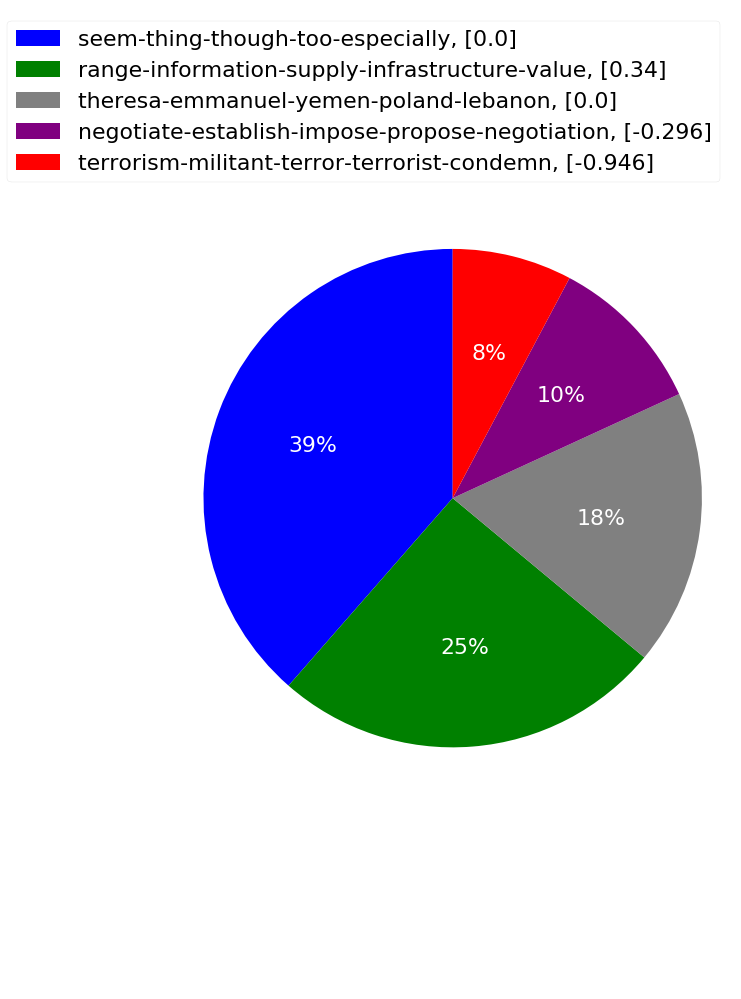

In [15]:
desc_palette = dict()
color_choices = ['blue', 'green', 'grey', 'purple', 'red', 'yellow']

desc_pie_sizes = []
desc_pie_labels = []

sum_all_shares = sum([v for k, v in major_desc_sum_dict.items()])
for i, (desc_i, sum_share) in enumerate(sorted([(k, v) for k, v in major_desc_sum_dict.items()], key=lambda x: -x[1])):
    print(rmn_descs[desc_i], '\t\t', sum_share / sum_all_shares)
    desc_palette[desc_i] = color_choices[i % len(color_choices)]
    desc_pie_sizes.append(sum_share)
    desc_pie_labels.append(rmn_descs[desc_i])
sdps = sum(desc_pie_sizes)
for i in range(len(desc_pie_sizes)):
    desc_pie_sizes[i] /= sdps
    
sns.set_context("notebook", font_scale=2.2)
plt.figure(figsize=(10,18))
patches, _, _ = plt.pie(desc_pie_sizes, autopct='%1.0f%%', startangle=90, colors=color_choices, textprops=dict(color="w",fontsize='small'))
plt.legend(patches, desc_pie_labels, loc="best")
plt.axis('equal')

## Main Visualization

In [16]:
def e2er_visualization(b_name, rel, desc_share_d, attn_dict, baseline_d, rmn_descs, desc_palette, key_event_dict):
    print('##################', rel, '##################')
    sns.set_style("ticks")
    sns.set_context("notebook", font_scale=3.2, rc={"lines.linewidth": 2}) # previous font: 2.2
    if len(desc_share_d['desc_type']) == 0:
        return
    desc_share_df = pd.DataFrame(data=desc_share_d)
    plt.figure(figsize=(20,8))
    ax = sns.pointplot(data=desc_share_df, x='month_info', y='desc_share', hue='desc_type',
                       ci=None, palette=desc_palette, markers=['o', 'x', '^'], scale=1.5)
    plt.setp([ax.get_lines()],alpha=.5)
    ax.legend(loc='center left', bbox_to_anchor=(0, 1.3))
    new_title = 'Descriptor Type'
    ax.legend_.set_title(new_title)
    for t in ax.legend_.texts:
        t.set_text(rmn_descs[int(t.get_text())].split(',')[0])
    key_event_count = 0
    for xl in ax.get_xticklabels():
        if xl.get_text()[2:] in key_event_dict[b_name][rel].keys():
            key_event_text = key_event_dict[b_name][rel][xl.get_text()[2:]].split('(')[0]
            x_coor = str_to_month(xl.get_text()[2:], year_base) - 1
            plt.axvline(x=x_coor, linestyle='--', color='black', alpha=0.5, lw = 2)
#             trans = ax.get_xaxis_transform() # x in data untis, y in axes fraction
#             ax.annotate(key_event_text, xy=(x_coor, -0.18),  xycoords=trans,
#                         xytext=(0, -.325 - (key_event_count) * .15), textcoords=trans,
#                         bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
#                         arrowprops=dict(arrowstyle="-|>", lw=2,
#                                         connectionstyle="angle,angleA=0,angleB=80,rad=20"))
            key_event_count += 1
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    ax.xaxis.set_label_text('')
    ax.yaxis.set_label_text('Descriptor Weight')
    plt.show()
#     ax.figure.savefig('figures/mohit_' + rel + '.png', dpi=200, bbox_inches='tight')

################## U.S. AND U.K. ##################


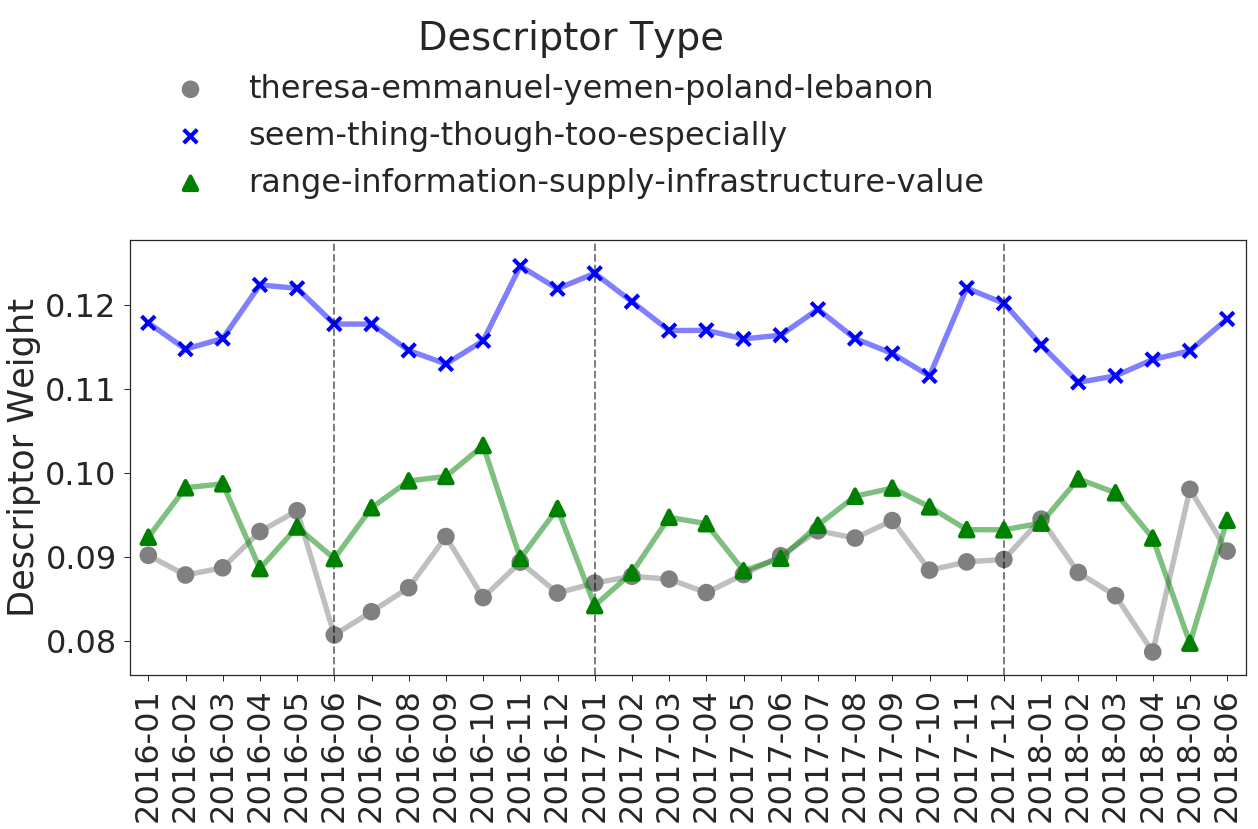

################## U.S. AND Japan ##################


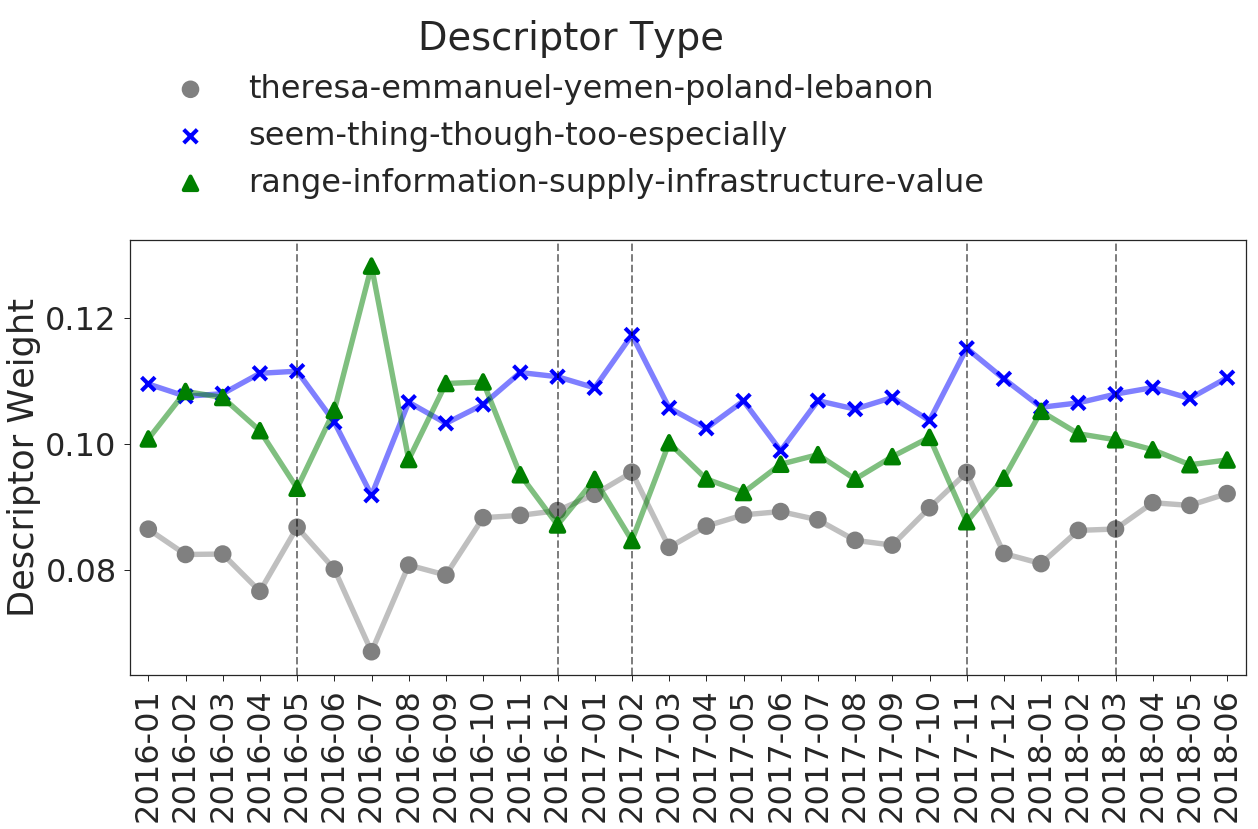

################## U.S. AND Syria ##################


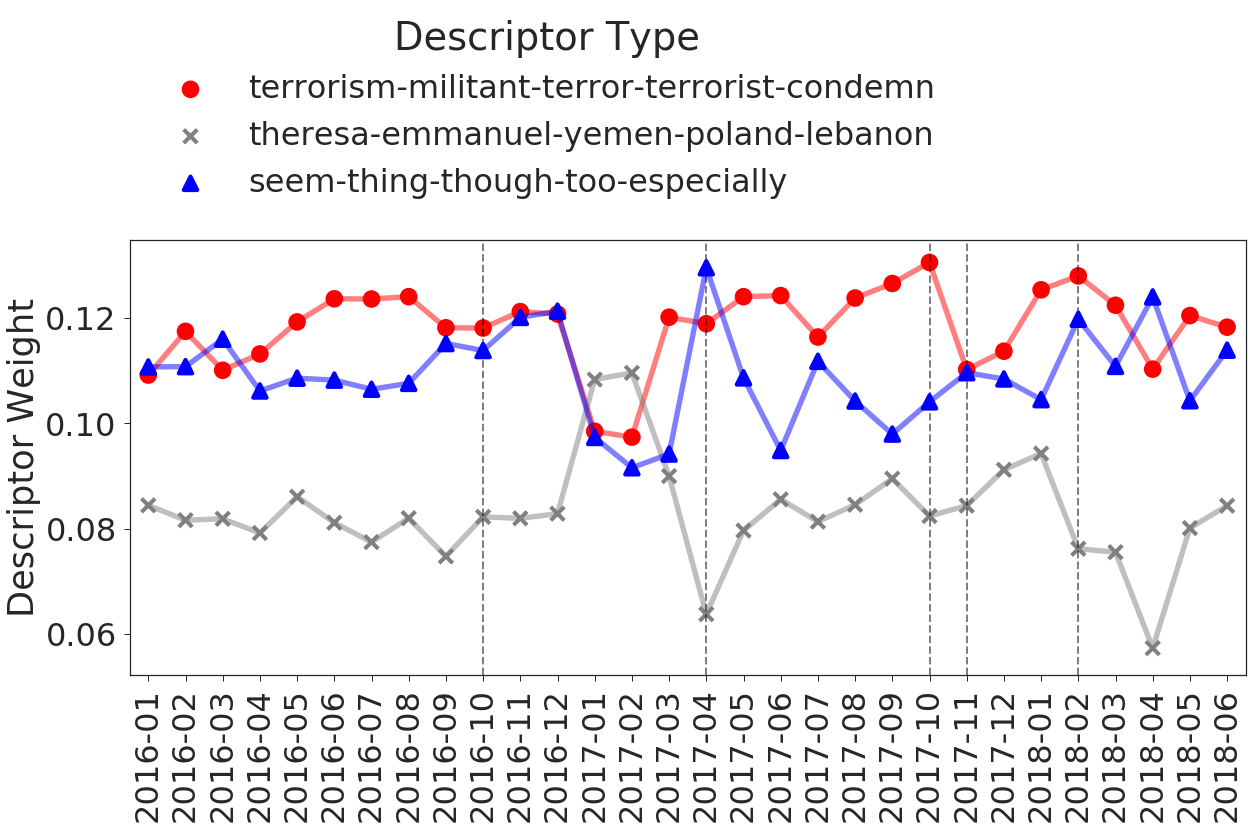

################## U.S. AND Russia ##################


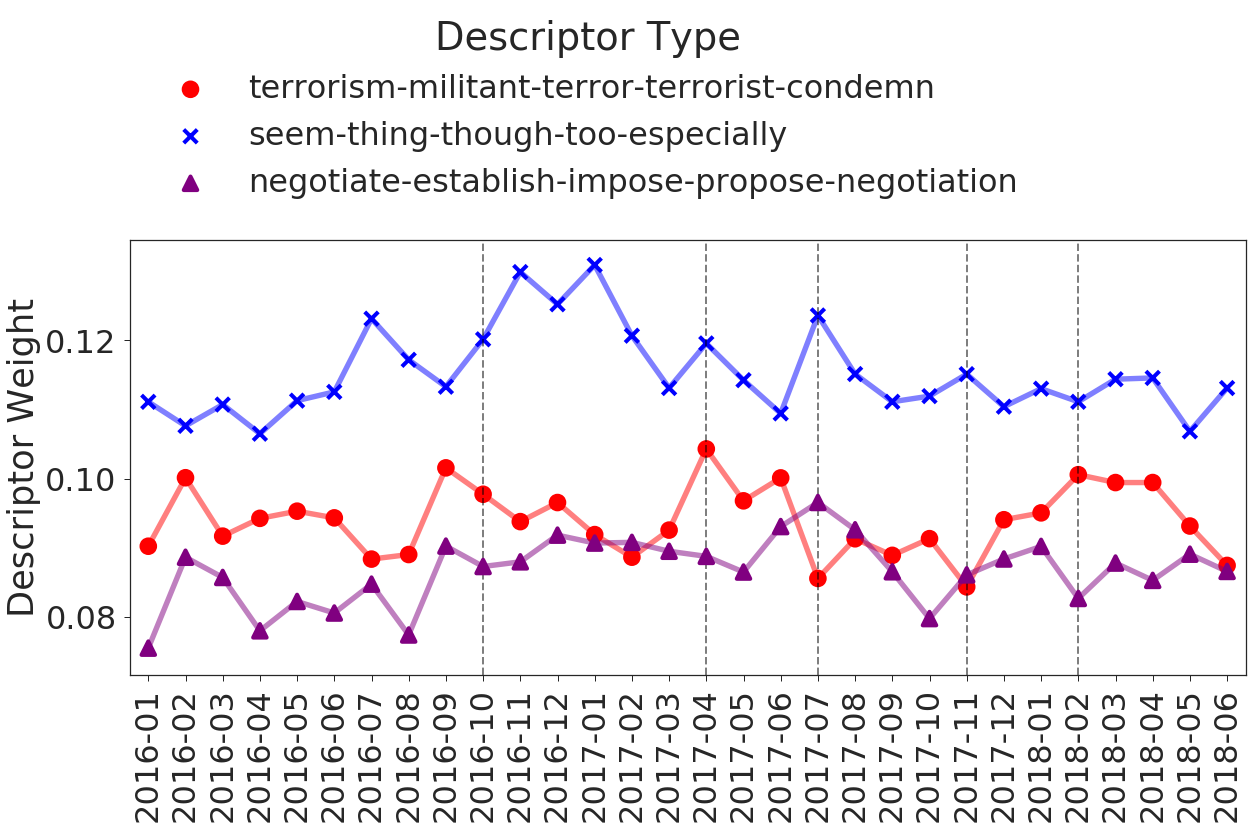

################## U.S. AND China ##################


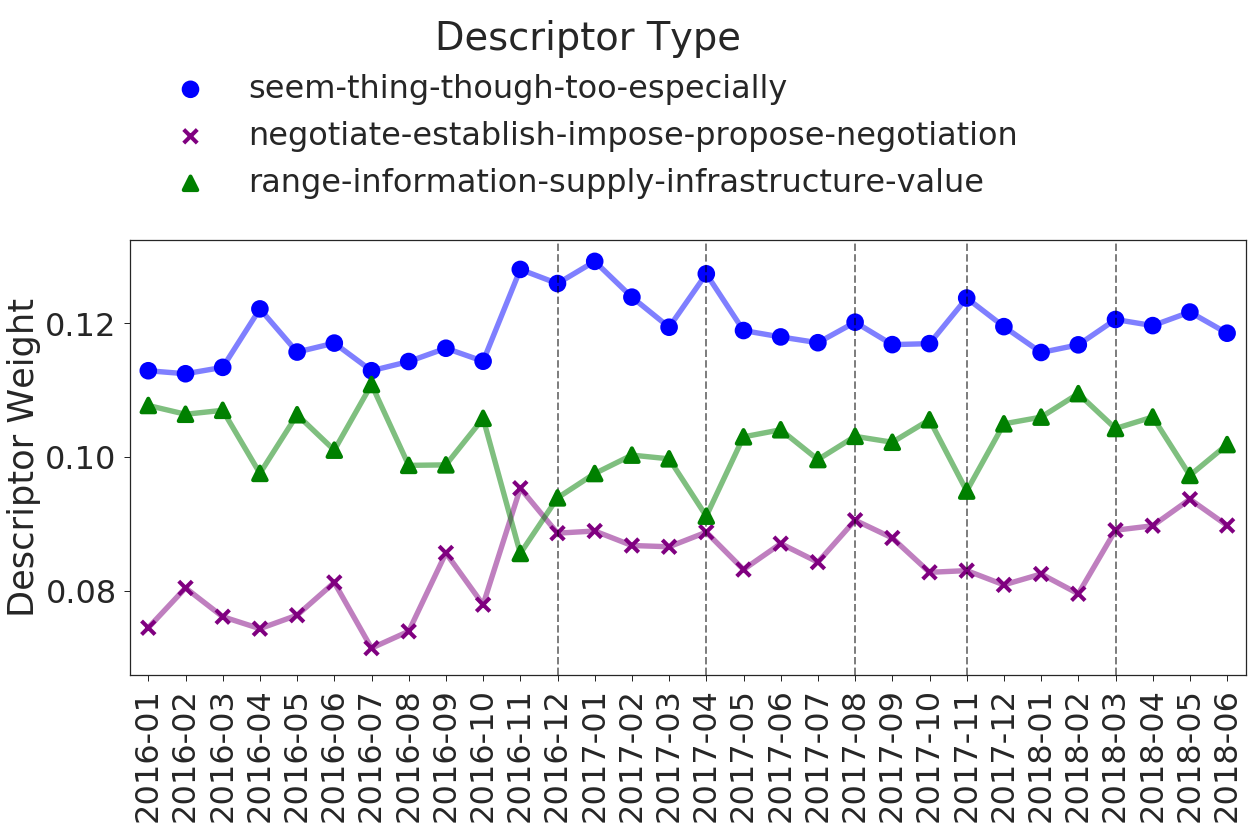

################## U.S. AND Canada ##################


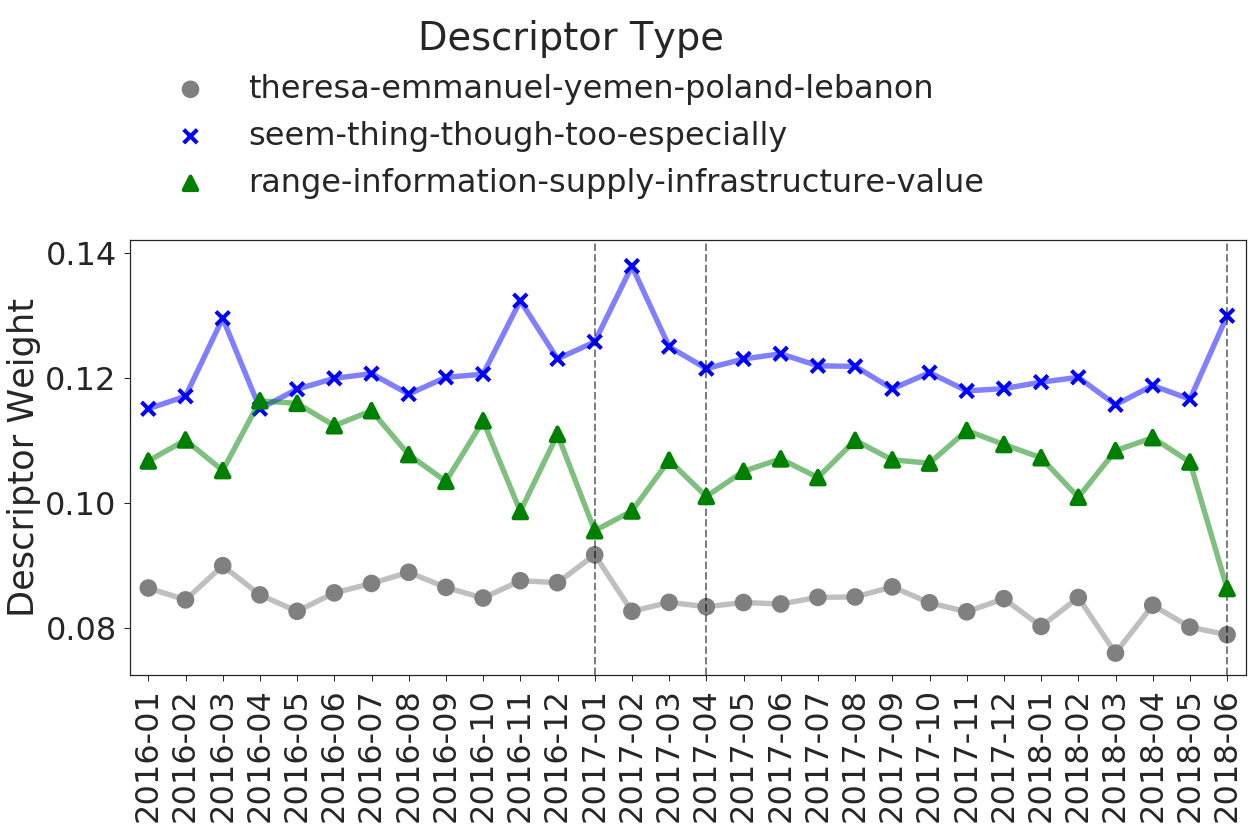

################## China AND India ##################


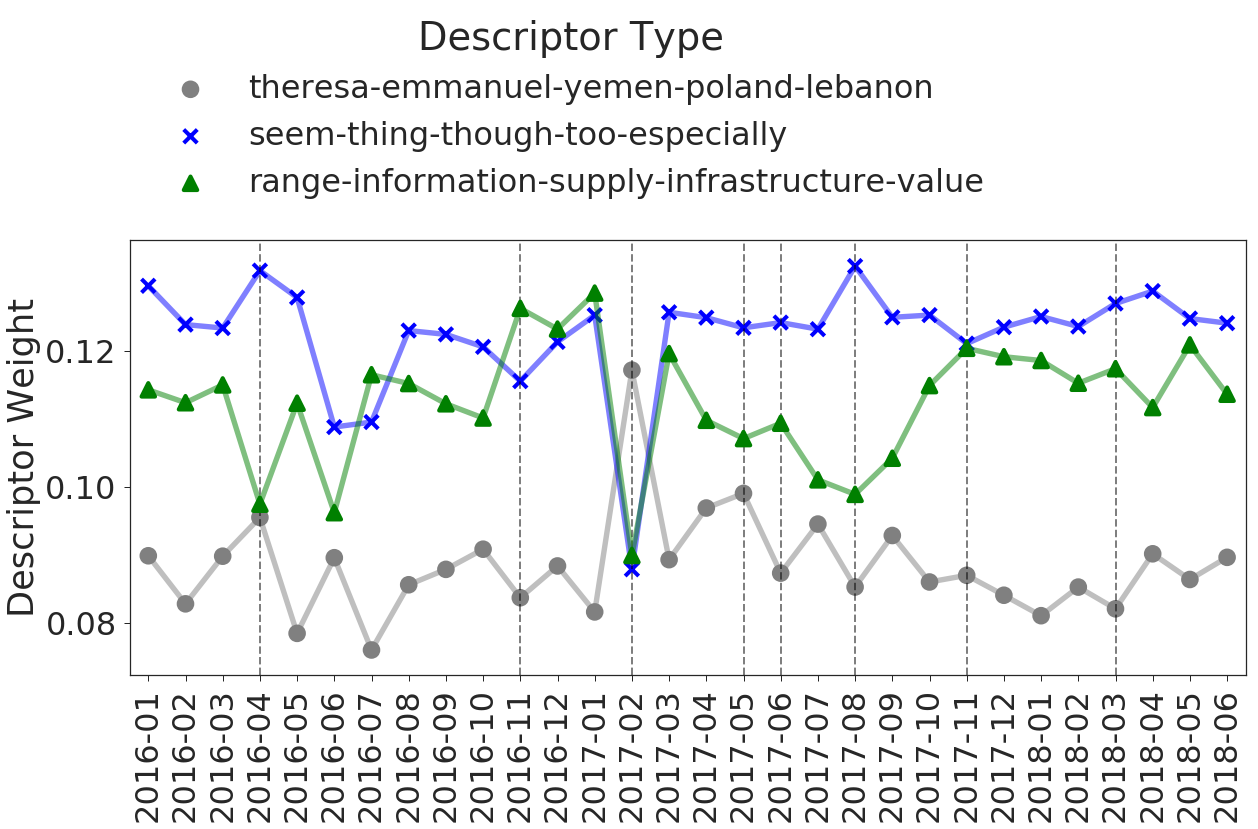

################## U.S. AND India ##################


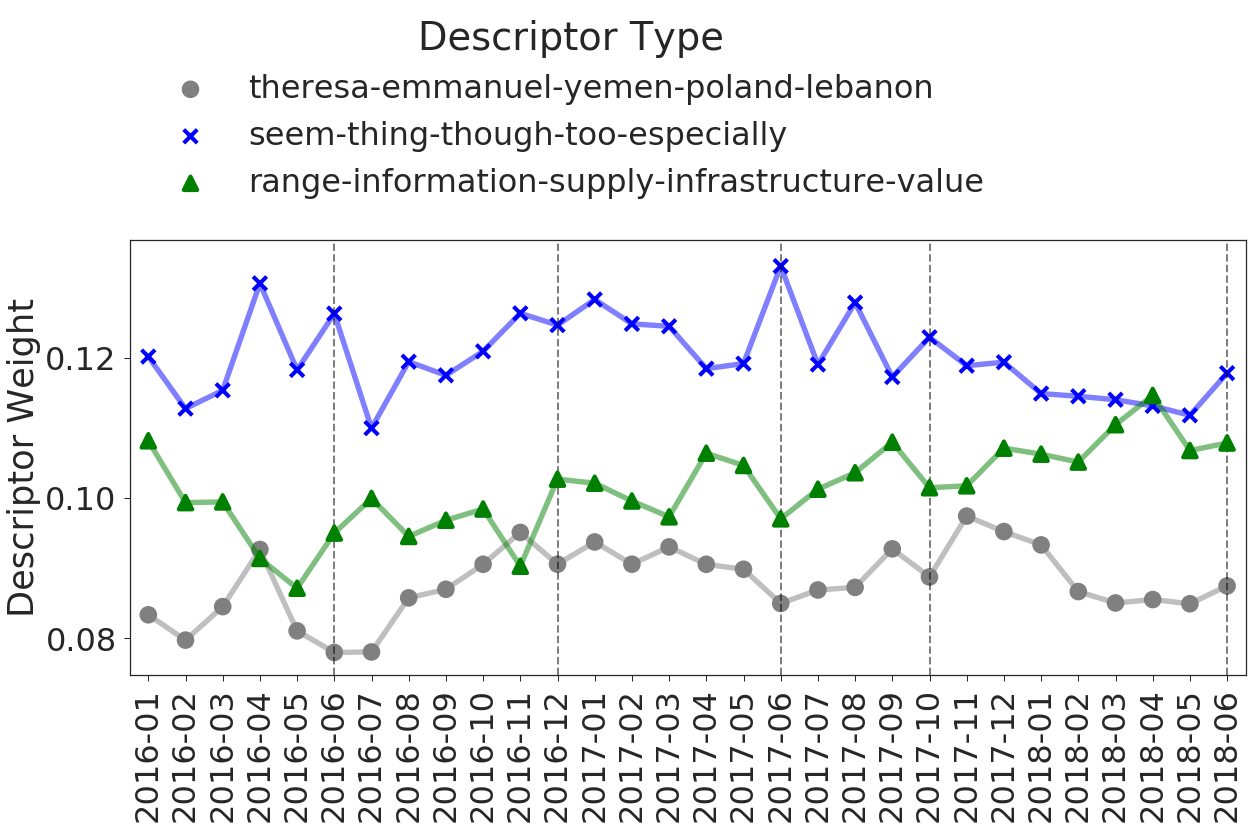

In [17]:
for rel in vis_dict.keys():
    e2er_visualization('Internation', rel, vis_dict[rel][0], dict(), dict(),
                       rmn_descs, desc_palette, key_event_dict)

## For change point analysis

In [18]:
# move to a new notebook to do this
pickle.dump((vis_dict, key_event_dict), open('change_point_resource_mohit.pkl', 'wb'))